# **Pothole Classification Pipeline — Transformers, CNNs, Ensemble & XAI**

This notebook presents an end-to-end pothole detection pipeline combining **vision transformers**, **convolutional networks**, **cross-validation**, **ensemble learning**, and a structured **explainability framework**.

---

## **Models Used**
All models are ImageNet-pretrained and fine-tuned for binary classification:

- Vision Transformer (ViT-Base)
- Swin Transformer (Swin-Tiny)
- EfficientNet-B0
- ResNet50

Model diversity enables:
- **Transformers** → global context and structure
- **CNNs** → local textures, cracks, and surface patterns

---

## **Pipeline Overview**
- Dataset loading, preprocessing, and augmentation
- CNN- and ViT-compatible Albumentations pipeline
- Mixed-precision training (AMP)
- Cosine learning-rate scheduling with warmup
- Selective layer freezing for CNN fine-tuning
- Individual model training and evaluation
- K-Fold cross-validation across all architectures
- Weighted ensemble for improved robustness

### **Evaluation Metrics**
- Accuracy
- F1-score
- Confusion matrix
- ROC–AUC
- Precision–Recall (Average Precision)

---

## **Explainability (XAI)**
A multi-method interpretability suite to analyze model decisions:

- **Grad-CAM (EfficientNet, ResNet50)**  
  Visualizes spatial activations responsible for pothole predictions.

- **SHAP (ViT)**  
  Pixel-level attribution using KernelExplainer.

- **LIME (ViT)**  
  Superpixel-based local explanations.

- **t-SNE Embeddings**  
  2D visualization of latent feature separability between classes.

---

## **Objective**
To build a **robust, interpretable pothole detection system** by integrating:
- complementary vision architectures
- cross-validated training
- ensemble inference
- transparent model explanations

The pipeline emphasizes both **performance** and **trustworthiness**.

## 1. Install Required Libraries
We install all necessary libraries: PyTorch, timm, albumentations, SHAP, LIME, Captum, UMAP, etc.
This ensures the entire ViT-first pipeline runs in Google Colab.

In [2]:
!pip install -q kaggle torch torchvision torchaudio timm albumentations opencv-python \
    matplotlib seaborn scikit-learn pandas tqdm lightning transformers \
    captum shap lime umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 47.9 MB/s eta 0:00:00


## 2. Upload kaggle.json  
Since we are in Colab, we manually upload kaggle.json so the Kaggle API can download the dataset automatically.

In [3]:
from google.colab import files
uploaded = files.upload()

import os, shutil
os.makedirs("/root/.kaggle", exist_ok=True)

if "kaggle.json" in uploaded:
    shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
else:
    raise ValueError("Please upload kaggle.json")

os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("Kaggle API configured successfully!")

Saving kaggle.json to kaggle.json
Kaggle API configured successfully!


## 3. Download Dataset from Kaggle  
We now download the pothole detection dataset and extract it into `data/raw/`.

In [4]:
!mkdir -p data/raw
!kaggle datasets download -d atulyakumar98/pothole-detection-dataset -p data/raw --unzip
print("Dataset downloaded.")

Dataset URL: https://www.kaggle.com/datasets/atulyakumar98/pothole-detection-dataset
License(s): CC0-1.0
 85% 164M/194M [00:00<00:00, 300MB/s]
100% 194M/194M [00:00<00:00, 313MB/s]
Dataset downloaded.


## 4. Prepare Directory Structure  
The downloaded dataset uses `Plain/` and `Potholes/`.  
We convert them into the required structure:

normal → Plain  
pothole → Potholes  

Then we create train/val/test splits.

In [5]:
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split

RAW = Path("data/raw")
PROC = Path("data/processed")

# Correct folder names
src_normal  = RAW / "normal"
src_pothole = RAW / "potholes"

print("Normal folder exists:", src_normal.exists(), "Count:", len(list(src_normal.glob('*'))))
print("Pothole folder exists:", src_pothole.exists(), "Count:", len(list(src_pothole.glob('*'))))

# Create processed directories
for split in ["train", "val", "test"]:
    (PROC / split / "normal").mkdir(parents=True, exist_ok=True)
    (PROC / split / "pothole").mkdir(parents=True, exist_ok=True)

def split_and_copy(source, cls_name):
    files = [str(p) for p in Path(source).glob("*.*")]

    if len(files) == 0:
        raise ValueError(f"Folder {source} is EMPTY. Check your dataset path!")

    train, temp = train_test_split(
        files,
        train_size=0.7,
        random_state=42,
        shuffle=True
    )
    val, test  = train_test_split(temp, test_size=0.5, random_state=42)

    for file_list, split in [(train, "train"), (val, "val"), (test, "test")]:
        dest = PROC / split / cls_name
        for f in file_list:
            shutil.copy(f, dest / Path(f).name)

    return len(train), len(val), len(test)

print("Normal split:",  split_and_copy(src_normal,  "normal"))
print("Pothole split:", split_and_copy(src_pothole, "pothole"))

Normal folder exists: True Count: 352
Pothole folder exists: True Count: 329
Normal split: (246, 53, 53)
Pothole split: (230, 49, 50)


## 5. Define Transforms and Dataset  
We apply ViT-friendly augmentations: random crop, color jitter, coarse dropout, etc.  
All images are resized to 224x224 for ViT-Small.

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2, torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

IMAGE_SIZE = 224
BATCH_SIZE = 16

train_tfms = A.Compose([
    A.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=(0.7, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(blur_limit=(3,5), p=0.15),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.3),

    # Stabilizes CNNs greatly & improves transformer robustness
    A.CoarseDropout(
        num_holes_range=(1, 2),
        hole_height_range=(20, 40),
        hole_width_range=(20, 40),
        fill=0,
        p=0.3
    ),

    # Correct ImageNet normalization (CRITICAL for EffNet/ResNet)
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2(),
])

val_tfms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2(),
])

# Dataset Class
class RoadDataset(Dataset):
    def __init__(self, root, split, tfms):
        self.samples = []
        for cls_idx, cls_name in enumerate(["normal", "pothole"]):
            folder = Path(root) / split / cls_name
            for f in folder.glob("*.*"):
                self.samples.append((str(f), cls_idx))
        self.tfms = tfms

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = self.tfms(image=img)["image"]
        return img, torch.tensor(label)

# Dataloaders
train_ds = RoadDataset(PROC, "train", train_tfms)
val_ds   = RoadDataset(PROC, "val",   val_tfms)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)

## 6. Model Builder Functions (ViT, Swin, EfficientNet, ResNet50)

We define reusable model-builder functions for each architecture.
K-Fold training will call these functions to create a fresh model for every fold, ensuring clean weight initialization and no cross-contamination across folds.

In [19]:
import timm

# Backbone utils
def freeze_backbone(model):
    for p in model.parameters():
        p.requires_grad = False
    return model

def unfreeze_head(model):
    # ViT / Swin
    if hasattr(model, "head") and model.head is not None:
        for p in model.head.parameters():
            p.requires_grad = True
        return model

    # EfficientNet
    if hasattr(model, "classifier") and model.classifier is not None:
        for p in model.classifier.parameters():
            p.requires_grad = True
        return model

    # ResNet
    if hasattr(model, "fc") and model.fc is not None:
        for p in model.fc.parameters():
            p.requires_grad = True
        return model

    print("[INFO] No explicit classifier head found (safe to ignore)")
    return model

# Model builders
def build_vit(n_classes=2):
    model = timm.create_model(
        "vit_base_patch16_224",
        pretrained=True,
        num_classes=n_classes
    )
    freeze_backbone(model)
    unfreeze_head(model)
    return model


def build_swin(n_classes=2):
    model = timm.create_model(
        "swin_tiny_patch4_window7_224",
        pretrained=True,
        num_classes=n_classes
    )
    freeze_backbone(model)
    unfreeze_head(model)
    return model


def build_effnet_pretrained(n_classes=2):
    model = timm.create_model(
        "efficientnet_b0",
        pretrained=True,
        num_classes=n_classes
    )
    freeze_backbone(model)
    unfreeze_head(model)
    return model


def build_resnet50_pretrained(n_classes=2):
    model = timm.create_model(
        "resnet50",
        pretrained=True,
        num_classes=n_classes
    )
    freeze_backbone(model)
    unfreeze_head(model)
    return model

## 7. Training & Validation Functions  
We define a clean training loop with mixed precision.  
We will perform baseline training for each model.

In [14]:
import torch
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def train_epoch(model, loader, opt, criterion, scaler):
    model.train()
    losses, preds, labs = [], [], []

    for x,y in loader:
        x,y = x.to(device),y.to(device)
        opt.zero_grad()
        with autocast():
            out = model(x)
            loss = criterion(out, y)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        losses.append(loss.item())
        preds += out.argmax(1).cpu().tolist()
        labs  += y.cpu().tolist()

    return sum(losses)/len(losses), accuracy_score(labs,preds), f1_score(labs,preds)

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    losses, preds, labs, probs = [], [], [], []
    for x,y in loader:
        x,y = x.to(device),y.to(device)
        out = model(x)
        loss = criterion(out,y)
        losses.append(loss.item())
        preds += out.argmax(1).cpu().tolist()
        probs += torch.softmax(out,dim=1)[:,1].cpu().tolist()
        labs  += y.cpu().tolist()

    return (
        sum(losses)/len(losses),
        accuracy_score(labs,preds),
        f1_score(labs,preds),
        roc_auc_score(labs,probs)
    )

def fit(model, epochs, lr, run_name):
    opt = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4,
    weight_decay=0.05
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    scaler = GradScaler()

    hist = {"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}

    MAX_EPOCHS = 10
    PATIENCE = 2

    best_f1 = -1
    wait = 0

    for ep in range(1, MAX_EPOCHS + 1):
        tr_l,tr_a,_ = train_epoch(...)
        val_l,val_a,val_f1,_ = validate(...)

        if val_f1 > best_f1:
            best_f1 = val_f1
            wait = 0
            torch.save(model.state_dict(), f"models/{run_name}.pth")
        else:
            wait += 1
            if wait >= PATIENCE:
                break

    return hist

## 8. Train Vision Transformer
We train Vision Transformer - Baseline training (10 epochs).
We plot accuracy/loss.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Training ViT (Baseline)...
vit_base | Epoch 1/10 | train_loss=0.7962 val_loss=0.4449 val_acc=0.8725
vit_base | Epoch 2/10 | train_loss=0.3657 val_loss=0.2540 val_acc=0.9804
vit_base | Epoch 3/10 | train_loss=0.2794 val_loss=0.2436 val_acc=0.9902
vit_base | Epoch 4/10 | train_loss=0.2627 val_loss=0.2437 val_acc=0.9902
vit_base | Epoch 5/10 | train_loss=0.2564 val_loss=0.2445 val_acc=0.9902
vit_base | Epoch 6/10 | train_loss=0.2545 val_loss=0.2424 val_acc=0.9804
vit_base | Epoch 7/10 | train_loss=0.2444 val_loss=0.2416 val_acc=0.9804
vit_base | Epoch 8/10 | train_loss=0.2446 val_loss=0.2419 val_acc=0.9902
vit_base | Epoch 9/10 | train_loss=0.2445 val_loss=0.2417 val_acc=0.9902
vit_base | Epoch 10/10 | train_loss=0.2436 val_loss=0.2417 val_acc=0.9902


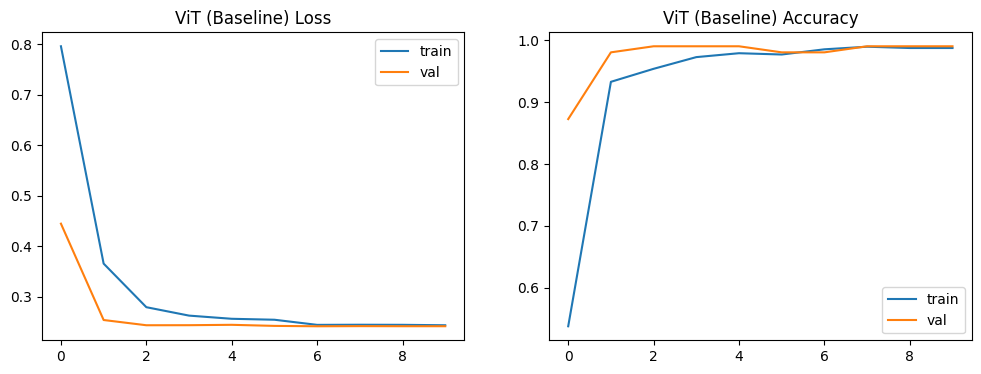

In [ ]:
import timm
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
Path("models").mkdir(exist_ok=True)

# Plot History
def plot_hist(h, title):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(h["train_loss"], label="train")
    plt.plot(h["val_loss"],   label="val")
    plt.title(f"{title} Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h["train_acc"], label="train")
    plt.plot(h["val_acc"],   label="val")
    plt.title(f"{title} Accuracy"); plt.legend()

    plt.show()

# LR Scheduler
def build_scheduler(optimizer, warmup_epochs, total_epochs):
    def warmup_lambda(epoch):
        return (epoch + 1) / warmup_epochs if epoch < warmup_epochs else 1.0

    warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
    cosine_scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)
    return warmup_scheduler, cosine_scheduler

# Training Loop
def fit(model, epochs, lr, run_name):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4
    )

    scaler = GradScaler("cuda")

    warmup_epochs = 3
    warmup_sched, cosine_sched = build_scheduler(optimizer, warmup_epochs, epochs)

    history = {k: [] for k in ["train_loss","train_acc","val_loss","val_acc"]}
    best_f1 = -1

    for ep in range(1, epochs + 1):
        model.train()
        train_losses, train_preds, train_labels = [], [], []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                out = model(x)
                loss = criterion(out, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())
            train_preds.extend(out.argmax(1).cpu().tolist())
            train_labels.extend(y.cpu().tolist())

        train_loss = sum(train_losses)/len(train_losses)
        train_acc  = accuracy_score(train_labels, train_preds)

        model.eval()
        val_losses, val_preds, val_labels = [], [], []

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)

                val_losses.append(loss.item())
                val_preds.extend(out.argmax(1).cpu().tolist())
                val_labels.extend(y.cpu().tolist())

        val_loss = sum(val_losses)/len(val_losses)
        val_acc  = accuracy_score(val_labels, val_preds)
        val_f1   = f1_score(val_labels, val_preds)

        # Record history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"{run_name} | Epoch {ep}/{epochs} | "
              f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"models/{run_name}.pth")

        (warmup_sched if ep <= warmup_epochs else cosine_sched).step()

    return history

# Train ViT (Baseline)
torch.cuda.empty_cache()
vit = build_vit().to(device)

print("Training ViT (Baseline)...")
hist_vit = fit(vit, epochs=10, lr=3e-4, run_name="vit_base")
plot_hist(hist_vit, "ViT (Baseline)")

## 9. Train Swin Transformer  
Similarly, we train Swin Transformer - Baseline training (7 epochs).
We plot accuracy/loss.

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Training Swin (Baseline)...
swin_base | Epoch 1/10 | train_loss=0.6217 val_loss=0.5017 val_acc=0.8431
swin_base | Epoch 2/10 | train_loss=0.4578 val_loss=0.3327 val_acc=0.9902
swin_base | Epoch 3/10 | train_loss=0.3515 val_loss=0.2699 val_acc=0.9804
swin_base | Epoch 4/10 | train_loss=0.3117 val_loss=0.2563 val_acc=0.9804
swin_base | Epoch 5/10 | train_loss=0.2860 val_loss=0.2528 val_acc=0.9804
swin_base | Epoch 6/10 | train_loss=0.2756 val_loss=0.2517 val_acc=0.9804
swin_base | Epoch 7/10 | train_loss=0.2773 val_loss=0.2510 val_acc=0.9804
swin_base | Epoch 8/10 | train_loss=0.2732 val_loss=0.2509 val_acc=0.9804
swin_base | Epoch 9/10 | train_loss=0.2664 val_loss=0.2508 val_acc=0.9804
swin_base | Epoch 10/10 | train_loss=0.2689 val_loss=0.2509 val_acc=0.9804


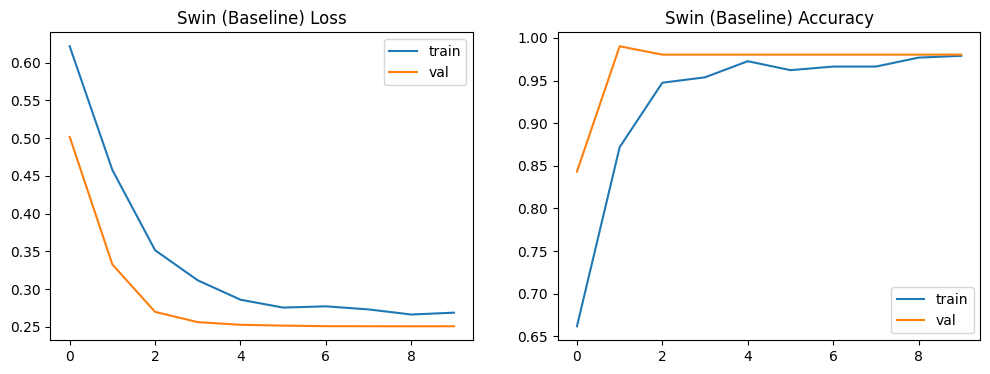

In [ ]:
torch.cuda.empty_cache()
swin = build_swin().to(device)

print("Training Swin (Baseline)...")
hist_swin = fit(swin, epochs=10, lr=3e-4, run_name="swin_base")
plot_hist(hist_swin, "Swin (Baseline)")

## 10. Train EfficientNetB0 (CNN Baseline)

EfficientNetB0 learns local textures, which complement the global structure modeling of Vision and Swin Transformers.
This model helps the ensemble fix texture-based pothole classification errors.

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Freezing early EfficientNet layers...
Training Pretrained EfficientNetB0...
effnet_pretrained | Ep 1/10 | train_loss 1.3773 val_loss 0.8667 val_acc 0.9118
effnet_pretrained | Ep 2/10 | train_loss 0.9977 val_loss 0.8800 val_acc 0.9216
effnet_pretrained | Ep 3/10 | train_loss 0.9122 val_loss 0.9089 val_acc 0.9412
effnet_pretrained | Ep 4/10 | train_loss 0.9628 val_loss 0.6895 val_acc 0.9510
effnet_pretrained | Ep 5/10 | train_loss 0.8917 val_loss 0.6278 val_acc 0.9804
effnet_pretrained | Ep 6/10 | train_loss 0.7302 val_loss 0.6438 val_acc 0.9706
effnet_pretrained | Ep 7/10 | train_loss 0.6732 val_loss 0.5535 val_acc 0.9510
effnet_pretrained | Ep 8/10 | train_loss 0.6544 val_loss 0.5396 val_acc 0.9608
effnet_pretrained | Ep 9/10 | train_loss 0.6037 val_loss 0.5458 val_acc 0.9412
effnet_pretrained | Ep 10/10 | train_loss 0.5810 val_loss 0.5105 val_acc 0.9412


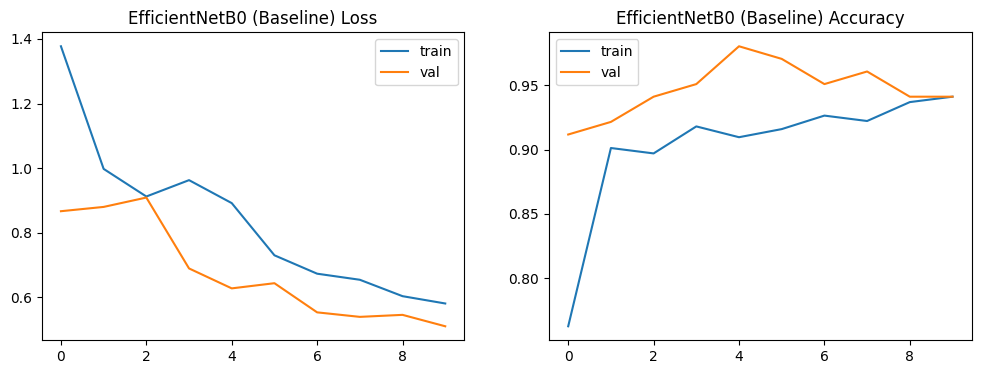

In [ ]:
import timm
import torch
import torch.nn as nn
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR

def build_effnet_pretrained(n_classes=2):
    model = timm.create_model(
        "efficientnet_b0",
        pretrained=True,
        num_classes=n_classes,
        drop_rate=0.2,
        drop_path_rate=0.2
    )
    return model

def freeze_effnet(model, freeze_ratio=0.6):
    total_blocks = len(model.blocks)
    freeze_until = int(total_blocks * freeze_ratio)

    for idx, block in enumerate(model.blocks):
        if idx < freeze_until:
            for param in block.parameters():
                param.requires_grad = False

    for param in model.conv_head.parameters():
        param.requires_grad = True
    for param in model.bn1.parameters():
        param.requires_grad = True
    for param in model.classifier.parameters():
        param.requires_grad = True

def make_scheduler(optimizer, warmup_epochs, total_epochs):
    def warmup_lambda(epoch):
        return min(1.0, (epoch + 1) / warmup_epochs)

    warmup = LambdaLR(optimizer, lr_lambda=warmup_lambda)
    cosine = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)

    return warmup, cosine

def fit_effnet(model, epochs, lr, run_name):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4
    )

    scaler = GradScaler("cuda")

    warmup_epochs = 3
    warmup_sched, cosine_sched = make_scheduler(optimizer, warmup_epochs, epochs)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_f1 = -1

    for ep in range(epochs):
        model.train()
        train_losses, preds, labs = [], [], []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                out = model(x)
                loss = criterion(out, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())
            preds += out.argmax(1).cpu().tolist()
            labs  += y.cpu().tolist()

        train_loss = sum(train_losses)/len(train_losses)
        train_acc = accuracy_score(labs, preds)

        model.eval()
        vlosses, vpreds, vlabs = [], [], []

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)

                vlosses.append(loss.item())
                vpreds += out.argmax(1).cpu().tolist()
                vlabs  += y.cpu().tolist()

        val_loss = sum(vlosses)/len(vlosses)
        val_acc  = accuracy_score(vlabs, vpreds)
        val_f1   = f1_score(vlabs, vpreds)

        print(f"{run_name} | Ep {ep+1}/{epochs} | train_loss {train_loss:.4f} "
              f"val_loss {val_loss:.4f} val_acc {val_acc:.4f}")

        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"models/{run_name}.pth")

        # LR schedule
        if ep < warmup_epochs:
            warmup_sched.step()
        else:
            cosine_sched.step()

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

    return history

torch.cuda.empty_cache()
effnet = build_effnet_pretrained().to(device)

print("Freezing early EfficientNet layers...")
freeze_effnet(effnet)

print("Training Pretrained EfficientNetB0...")
hist_eff = fit_effnet(
    effnet,
    epochs=10,
    lr=1e-4,
    run_name="effnet_pretrained"
)

plot_hist(hist_eff, "EfficientNetB0 (Baseline)")

#11. Train ResNet50 (CNN Baseline)

ResNet50 is a deep convolutional architecture specializing in edge detection, texture modeling, and local features.
It captures road surface roughness and crack patterns that transformers sometimes overlook.
Adding ResNet50 strengthens the ensemble's diversity.

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Freezing ResNet50 backbone...
Training ResNet50 (Baseline)...
resnet50_pretrained | Ep 1/10 | train_loss 0.6523  val_loss 0.6232  val_acc 0.8824
resnet50_pretrained | Ep 2/10 | train_loss 0.5492  val_loss 0.4427  val_acc 0.9412
resnet50_pretrained | Ep 3/10 | train_loss 0.3868  val_loss 0.2643  val_acc 0.9804
resnet50_pretrained | Ep 4/10 | train_loss 0.2720  val_loss 0.2428  val_acc 0.9902
resnet50_pretrained | Ep 5/10 | train_loss 0.2448  val_loss 0.2382  val_acc 0.9902
resnet50_pretrained | Ep 6/10 | train_loss 0.2422  val_loss 0.2380  val_acc 0.9902
resnet50_pretrained | Ep 7/10 | train_loss 0.2383  val_loss 0.2408  val_acc 0.9902
resnet50_pretrained | Ep 8/10 | train_loss 0.2400  val_loss 0.2387  val_acc 0.9902
resnet50_pretrained | Ep 9/10 | train_loss 0.2295  val_loss 0.2415  val_acc 0.9902
resnet50_pretrained | Ep 10/10 | train_loss 0.2344  val_loss 0.2385  val_acc 0.9902


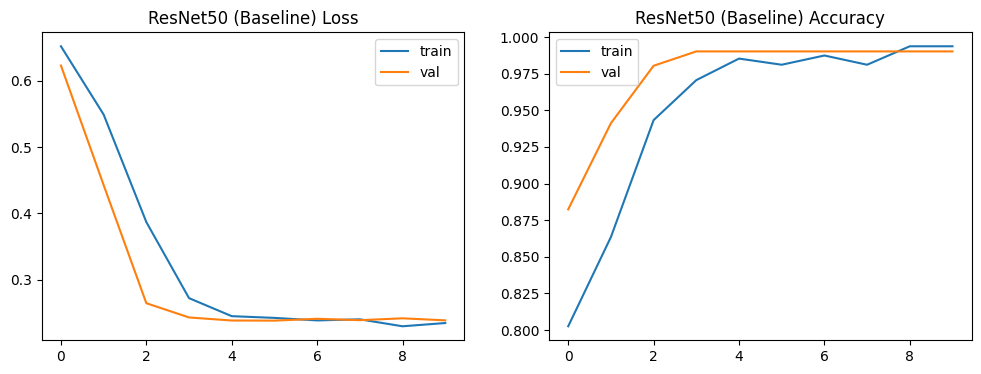

In [ ]:
import timm
import torch
import torch.nn as nn
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR

# Build ResNet50
def build_resnet50(n_classes=2):
    return timm.create_model(
        "resnet50",
        pretrained=True,
        num_classes=n_classes
    )

# Freeze Early Layers
def freeze_resnet(model, freeze_ratio=0.6):
    freeze_layers = ["conv1", "bn1", "layer1", "layer2"]
    for name, param in model.named_parameters():
        param.requires_grad = not any(layer in name for layer in freeze_layers)

# LR Scheduler
def make_scheduler(optimizer, warmup_epochs, total_epochs):
    warmup = LambdaLR(optimizer, lr_lambda=lambda e: min(1.0, (e + 1) / warmup_epochs))
    cosine = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)
    return warmup, cosine

# Training Loop
def fit_resnet(model, epochs, lr, run_name):
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4
    )

    scaler = GradScaler("cuda")
    warmup_epochs = 3
    warmup_sched, cosine_sched = make_scheduler(optimizer, warmup_epochs, epochs)

    history = {k: [] for k in ["train_loss","train_acc","val_loss","val_acc"]}
    best_f1 = -1

    for ep in range(1, epochs + 1):
        model.train()
        t_loss, t_preds, t_labels = [], [], []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                out = model(x)
                loss = criterion(out, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            t_loss.append(loss.item())
            t_preds.extend(out.argmax(1).cpu().tolist())
            t_labels.extend(y.cpu().tolist())

        train_loss = sum(t_loss) / len(t_loss)
        train_acc  = accuracy_score(t_labels, t_preds)

        model.eval()
        v_loss, v_preds, v_labels = [], [], []

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)

                v_loss.append(loss.item())
                v_preds.extend(out.argmax(1).cpu().tolist())
                v_labels.extend(y.cpu().tolist())

        val_loss = sum(v_loss) / len(v_loss)
        val_acc  = accuracy_score(v_labels, v_preds)
        val_f1   = f1_score(v_labels, v_preds)

        print(f"{run_name} | Ep {ep}/{epochs} | train_loss {train_loss:.4f}  "
              f"val_loss {val_loss:.4f}  val_acc {val_acc:.4f}")

        # Save best
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"models/{run_name}.pth")

        # Scheduler
        (warmup_sched if ep <= warmup_epochs else cosine_sched).step()

        # Log metrics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

    return history

# Run Training
torch.cuda.empty_cache()
resnet = build_resnet50().to(device)

print("Freezing ResNet50 backbone...")
freeze_resnet(resnet)

print("Training ResNet50 (Baseline)...")
hist_res = fit_resnet(
    resnet,
    epochs=10,
    lr=1e-4,
    run_name="resnet50_pretrained"
)

plot_hist(hist_res, "ResNet50 (Baseline)")

## 12. Final Ensemble of all Models
Now that all four models (Vision, Swin, EfficientNetB0, ResNet50) have been trained from scratch,
we load the best saved checkpoints and evaluate an ensemble combining their strengths.

In [ ]:
vit.load_state_dict(torch.load("models/vit_base.pth"))
swin.load_state_dict(torch.load("models/swin_base.pth"))
effnet.load_state_dict(torch.load("models/effnet_pretrained.pth"))
resnet.load_state_dict(torch.load("models/resnet50_pretrained.pth"))

vit.eval()
swin.eval()
effnet.eval()
resnet.eval()

@torch.no_grad()
def eval_weighted_ensemble(models, weights, loader):
    preds, labs = [], []
    w = torch.tensor(weights).float().view(-1, 1)

    for x, y in loader:
        x = x.to(device)

        # Compute pothole (class 1) probability from each model
        probs = [torch.softmax(m(x), dim=1)[:, 1].cpu() for m in models]

        # Weighted average probability
        combined = (torch.stack(probs) * w).sum(0) / w.sum()

        preds += (combined > 0.5).int().tolist()
        labs  += y.tolist()

    return accuracy_score(labs, preds), f1_score(labs, preds)

weights = [0.10, 0.05, 0.25, 0.60]

acc, f1 = eval_weighted_ensemble(
    [resnet, effnet, vit, swin],
    weights,
    val_loader
)

print("Weighted Ensemble Accuracy:", acc)
print("Weighted Ensemble F1:", f1)

Weighted Ensemble Accuracy: 0.9901960784313726
Weighted Ensemble F1: 0.98989898989899


## 13. K-Fold Cross-Validation

We use K-Fold Cross-Validation to evaluate model stability across different train/validation splits.  
Each fold trains a fresh instance of the model and reports accuracy/F1, giving a more reliable estimate of generalization.

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import gc
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score

BATCH_SIZE = 16

@torch.no_grad()
def eval_single_model(model, loader):
    preds, labs = [], []
    for x, y in loader:
        x = x.to(device)
        out = model(x)
        preds += out.argmax(1).cpu().tolist()
        labs  += y.tolist()
    acc = accuracy_score(labs, preds)
    f1  = f1_score(labs, preds)
    return acc, f1


def run_kfold(model_builder, dataset, k=5, epochs=10, lr=3e-4):
    print(f"\nRunning {k}-Fold Cross-Validation for: {model_builder.__name__}")

    if model_builder.__name__ == "build_effnet_pretrained":
        trainer_fn = fit_effnet
    elif model_builder.__name__ == "build_resnet50_pretrained":
        trainer_fn = fit_resnet
    else:
        trainer_fn = fit

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []

    idxs = np.arange(len(dataset))

    for fold, (train_idx, val_idx) in enumerate(kf.split(idxs)):
        print(f"\n========== Fold {fold+1}/{k} ==========")

        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset   = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(
            train_subset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_subset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

        model = model_builder().to(device)

        run_name = f"kfold_{model_builder.__name__}_fold{fold+1}"
        trainer_fn(
            model,
            epochs=epochs,
            lr=lr,
            run_name=run_name
        )

        ckpt_path = f"models/{run_name}.pth"
        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        model.eval()

        acc, f1 = eval_single_model(model, val_loader)
        print(f"Fold {fold+1} → Accuracy={acc:.4f}, F1={f1:.4f}")
        fold_metrics.append((acc, f1))

        del model
        gc.collect()
        torch.cuda.empty_cache()

    fold_metrics = np.array(fold_metrics)

    print("\n===== K-FOLD SUMMARY =====")
    print("Accuracy: {:.4f} ± {:.4f}".format(
        fold_metrics[:, 0].mean(), fold_metrics[:, 0].std()
    ))
    print("F1: {:.4f} ± {:.4f}".format(
        fold_metrics[:, 1].mean(), fold_metrics[:, 1].std()
    ))

    return fold_metrics

print("Running K-Fold for ViT...")
run_kfold(build_vit, train_ds, k=3, epochs=10, lr=3e-4)

print("Running K-Fold for Swin...")
run_kfold(build_swin, train_ds, k=3, epochs=10, lr=3e-4)

print("Running K-Fold for EfficientNet...")
run_kfold(build_effnet_pretrained, train_ds, k=3, epochs=10, lr=1e-4)

print("Running K-Fold for ResNet50...")
run_kfold(build_resnet50_pretrained, train_ds, k=3, epochs=10, lr=1e-4)

Running K-Fold for ViT...

Running 3-Fold Cross-Validation for: build_vit

========== Fold 1/3 ==========
kfold_build_vit_fold1 | Epoch 1/10 | train_loss=0.4821 val_loss=0.3424 val_acc=0.9314
kfold_build_vit_fold1 | Epoch 2/10 | train_loss=0.3034 val_loss=0.2732 val_acc=0.9510
kfold_build_vit_fold1 | Epoch 3/10 | train_loss=0.2614 val_loss=0.2613 val_acc=0.9804
kfold_build_vit_fold1 | Epoch 4/10 | train_loss=0.2508 val_loss=0.2521 val_acc=0.9804
kfold_build_vit_fold1 | Epoch 5/10 | train_loss=0.2512 val_loss=0.2528 val_acc=0.9804
kfold_build_vit_fold1 | Epoch 6/10 | train_loss=0.2417 val_loss=0.2518 val_acc=0.9804
kfold_build_vit_fold1 | Epoch 7/10 | train_loss=0.2363 val_loss=0.2451 val_acc=0.9804
kfold_build_vit_fold1 | Epoch 8/10 | train_loss=0.2405 val_loss=0.2480 val_acc=0.9804
kfold_build_vit_fold1 | Epoch 9/10 | train_loss=0.2400 val_loss=0.2460 val_acc=0.9804
kfold_build_vit_fold1 | Epoch 10/10 | train_loss=0.2355 val_loss=0.2457 val_acc=0.9804
Fold 1 → Accuracy=0.9811, F1=0.98

array([[0.96226415, 0.96      ],
       [0.96226415, 0.96103896],
       [0.94936709, 0.94736842]])

## 14. Ablation Studies (2-Fold Cross-Validation)

We perform controlled ablation studies using 2-fold cross-validation to analyze the impact of architectural choices, training strategies, and optimization components.

In [17]:
from sklearn.model_selection import KFold
import numpy as np
import torch
import gc
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import torch.nn as nn
import torch.nn.functional as F

K_ABLATION = 2
EPOCHS = 10
ABL_BATCH_SIZE = 16

train_ds_noaug = RoadDataset(PROC, "train", val_tfms)
train_ds_aug   = RoadDataset(PROC, "train", train_tfms)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, reduction="none")
        pt = torch.exp(-ce)
        return (((1 - pt) ** self.gamma) * ce).mean()

def ce_loss():
    return nn.CrossEntropyLoss(label_smoothing=0.1)

def focal_loss():
    return FocalLoss(gamma=2.0)

def train_epoch_ablation(model, loader, optimizer, criterion):
    model.train()
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

@torch.no_grad()
def eval_ablation(model, loader):
    preds, labs = [], []
    for x, y in loader:
        x = x.to(device)
        out = model(x)
        preds += out.argmax(1).cpu().tolist()
        labs  += y.tolist()
    return accuracy_score(labs, preds), f1_score(labs, preds)

def run_kfold_ablation(
    build_fn,
    dataset,
    loss_fn,
    k=3,
    epochs=10,
    lr=3e-4
):
    print(f"\nRunning {k}-Fold ABLATION → {build_fn.__name__} | Loss={loss_fn.__name__}")

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []
    idxs = np.arange(len(dataset))

    for fold, (train_idx, val_idx) in enumerate(kf.split(idxs)):
        print(f"\n---- Fold {fold+1}/{k} ----")

        train_ds = torch.utils.data.Subset(dataset, train_idx)
        val_ds   = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(
            train_ds,
            batch_size=ABL_BATCH_SIZE,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        val_loader = DataLoader(
            val_ds,
            batch_size=ABL_BATCH_SIZE,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

        model = build_fn().to(device)
        criterion = loss_fn()

        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=lr,
            weight_decay=0.05
        )

        best_f1 = -1.0
        ckpt = f"models/ablation_{build_fn.__name__}_{loss_fn.__name__}_fold{fold+1}.pth"

        for ep in range(epochs):
            train_epoch_ablation(model, train_loader, optimizer, criterion)
            acc, f1 = eval_ablation(model, val_loader)

            if f1 > best_f1:
                best_f1 = f1
                torch.save(model.state_dict(), ckpt)

        model.load_state_dict(torch.load(ckpt, map_location=device))
        model.eval()

        acc, f1 = eval_ablation(model, val_loader)
        print(f"Fold {fold+1} → Acc={acc:.4f}, F1={f1:.4f}")
        fold_metrics.append((acc, f1))

        del model
        torch.cuda.empty_cache()
        gc.collect()

    fold_metrics = np.array(fold_metrics)

    print("\nABLATION SUMMARY")
    print(f"Accuracy: {fold_metrics[:,0].mean():.4f} ± {fold_metrics[:,0].std():.4f}")
    print(f"F1:       {fold_metrics[:,1].mean():.4f} ± {fold_metrics[:,1].std():.4f}")

    return fold_metrics

import timm

# Backbone Utils
def freeze_backbone(model):
    for p in model.parameters():
        p.requires_grad = False

def unfreeze_head(model):
    if hasattr(model, "head") and model.head is not None:
        for p in model.head.parameters():
            p.requires_grad = True
        return

    if hasattr(model, "classifier") and model.classifier is not None:
        for p in model.classifier.parameters():
            p.requires_grad = True
        return

    if hasattr(model, "fc") and model.fc is not None:
        for p in model.fc.parameters():
            p.requires_grad = True
        return

    print("[INFO] No explicit classifier head found (safe for inference)")

# ViT
def build_vit_base(n_classes=2):
    model = timm.create_model(
        "vit_base_patch16_224",
        pretrained=True,
        num_classes=n_classes
    )
    freeze_backbone(model)
    unfreeze_head(model)
    return model


# EfficientNet
def build_effnet_frozen(n_classes=2):
    model = timm.create_model(
        "efficientnet_b0",
        pretrained=True,
        num_classes=n_classes
    )
    freeze_backbone(model)
    unfreeze_head(model)
    return model

def build_effnet_full(n_classes=2):
    model = timm.create_model(
        "efficientnet_b0",
        pretrained=True,
        num_classes=n_classes
    )
    return model


# ResNet
def build_resnet50_pretrained(n_classes=2):
    model = timm.create_model(
        "resnet50",
        pretrained=True,
        num_classes=n_classes
    )
    freeze_backbone(model)
    unfreeze_head(model)
    return model

def build_resnet50_scratch(n_classes=2):
    model = timm.create_model(
        "resnet50",
        pretrained=False,
        num_classes=n_classes
    )
    return model

In [16]:
print("\n========== ABLATION 1: PRETRAINED vs SCRATCH ==========")

run_kfold_ablation(
    build_resnet50_pretrained,
    train_ds_aug,
    ce_loss,
    k=K_ABLATION,
    epochs=EPOCHS,
    lr=1e-4
)

run_kfold_ablation(
    build_resnet50_scratch,
    train_ds_aug,
    ce_loss,
    k=K_ABLATION,
    epochs=EPOCHS,
    lr=1e-3
)

print("\n========== ABLATION 2: DATA AUGMENTATION ==========")

run_kfold_ablation(
    build_vit_base,
    train_ds_noaug,
    ce_loss,
    k=K_ABLATION,
    epochs=EPOCHS,
    lr=3e-4
)

run_kfold_ablation(
    build_vit_base,
    train_ds_aug,
    ce_loss,
    k=K_ABLATION,
    epochs=EPOCHS,
    lr=3e-4
)

print("\n========== ABLATION 3: BACKBONE FREEZING ==========")

run_kfold_ablation(
    build_effnet_frozen,
    train_ds_aug,
    ce_loss,
    k=K_ABLATION,
    epochs=EPOCHS,
    lr=1e-4
)

run_kfold_ablation(
    build_effnet_full,
    train_ds_aug,
    ce_loss,
    k=K_ABLATION,
    epochs=EPOCHS,
    lr=1e-4
)

print("\n========== ABLATION 4: LOSS FUNCTION ==========")

run_kfold_ablation(
    build_vit_base,
    train_ds_aug,
    ce_loss,
    k=K_ABLATION,
    epochs=EPOCHS,
    lr=3e-4
)

run_kfold_ablation(
    build_vit_base,
    train_ds_aug,
    focal_loss,
    k=K_ABLATION,
    epochs=EPOCHS,
    lr=3e-4
)


========== ABLATION 1: PRETRAINED vs SCRATCH ==========

Running 2-Fold ABLATION → build_resnet50_pretrained | Loss=ce_loss

---- Fold 1/2 ----


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

KeyboardInterrupt: 

## 15. Export Trained Model Checkpoints

After training, the final model weights are stored as `.pth` files.  
These checkpoints are downloaded from the runtime so they can be uploaded to Google Drive and/ or reused later for evaluation, inference, or XAI without retraining.

In [6]:
from google.colab import files

files.download("models/vit_base.pth")
files.download("models/swin_base.pth")
files.download("models/effnet_pretrained.pth")
files.download("models/resnet50_pretrained.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 16. Explainable AI (XAI): Grad-CAM, SHAP, LIME, and t-SNE

This section implements a unified explainability pipeline to understand **why** the models predict potholes, not just **what** they predict. Multiple complementary XAI methods are applied across CNNs and Transformers.

### Grad-CAM (EfficientNet-B0 & ResNet50)
Applied only to CNN-based models, Grad-CAM highlights spatial regions in the final convolutional layers that drive pothole predictions, such as cracks, edges, and surface irregularities.

### SHAP (Vision Transformer)
SHAP uses a KernelExplainer to provide pixel-level, model-agnostic attributions for ViT predictions, showing how individual pixels influence the pothole probability.

### LIME (Vision Transformer)
LIME explains individual predictions by perturbing superpixel regions, identifying which image regions most affect the ViT's output and complementing SHAP with local, region-based explanations.

### Evaluation Metrics (Post-XAI Validation)
All models are evaluated using Confusion Matrices, ROC-AUC, and Precision-Recall curves to verify that interpretability aligns with correct and reliable predictions.

### t-SNE Embedding Visualization
t-SNE projects high-dimensional latent embeddings from all models into 2D space, visualizing class separability and highlighting borderline or ambiguous samples.

### Summary
Together, these methods provide a complete interpretability framework:
- SHAP: pixel-wise attribution (ViT)
- Grad-CAM: spatial focus (CNNs)  
- LIME: region-level influence (ViT)  
- t-SNE: latent-space separability (all models)

In [8]:
import cv2, numpy as np, torch, gc
import matplotlib.pyplot as plt
from random import randint
import shap, lime
from lime import lime_image
import albumentations as A

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.manifold import TSNE

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

MODEL_DIR = "/content/drive/MyDrive/pothole_models"

import timm

device = "cuda" if torch.cuda.is_available() else "cpu"

Mounted at /content/drive


In [47]:
vit = build_vit_base().to(device)
swin = build_swin().to(device)
effnet = build_effnet_pretrained().to(device)
resnet = build_resnet50_pretrained().to(device)

vit.load_state_dict(torch.load(f"{MODEL_DIR}/vit_base.pth", map_location=device))
swin.load_state_dict(torch.load(f"{MODEL_DIR}/swin_base.pth", map_location=device))
effnet.load_state_dict(torch.load(f"{MODEL_DIR}/effnet_pretrained.pth", map_location=device))
resnet.load_state_dict(torch.load(f"{MODEL_DIR}/resnet50_pretrained.pth", map_location=device))

for m in [vit, swin, effnet, resnet]:
    m.eval()

In [56]:
def find_last_conv(model):
    for _, layer in reversed(list(model.named_modules())):
        if isinstance(layer, torch.nn.Conv2d):
            return layer
    return None

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        self.fwd = target_layer.register_forward_hook(self._forward)
        self.bwd = target_layer.register_full_backward_hook(self._backward)

    def _forward(self, m, i, o):
        self.activations = o

    def _backward(self, m, gi, go):
        self.gradients = go[0]

    def remove_hooks(self):
        self.fwd.remove()
        self.bwd.remove()

    def generate(self, x, class_idx=None):
        self.model.zero_grad(set_to_none=True)

        out = self.model(x)
        if class_idx is None:
            class_idx = out.argmax(dim=1)

        out[0, class_idx].backward()

        if self.gradients is None:
            raise RuntimeError("Gradients not captured")

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)

        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        self.remove_hooks()
        return cam

def show_random_gradcam(model, dataset, name):
    model.eval()

    idx = np.random.randint(len(dataset))
    img_path, _ = dataset.samples[idx]

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img_tensor = val_tfms(image=img)["image"].unsqueeze(0).to(device)

    if "EfficientNet" in name:
        target_layer = model.blocks[-1][-1].conv_pw
    elif "ResNet" in name:
        target_layer = model.layer4[-1].conv3
    else:
        raise ValueError("Grad-CAM only supported for CNNs")

    for p in target_layer.parameters():
        p.requires_grad = True

    with torch.enable_grad():
        cam = GradCAM(model, target_layer).generate(img_tensor)

    cam = cam.squeeze().detach().cpu().numpy()
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12,4))
    for i, (t, im) in enumerate([
        ("Original", img),
        ("Grad-CAM", heatmap),
        ("Overlay", overlay)
    ]):
        plt.subplot(1,3,i+1)
        plt.imshow(im)
        plt.title(t)
        plt.axis("off")

    plt.suptitle(f"Grad-CAM — {name}")
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

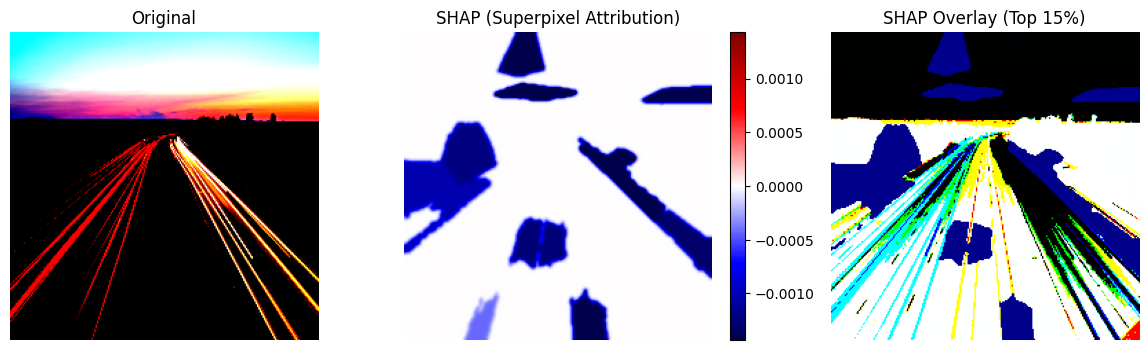

In [49]:
import shap
from skimage.segmentation import slic
from scipy.ndimage import gaussian_filter

# Move model to CPU (mandatory for SHAP)
vit_cpu = vit.to("cpu")
vit_cpu.eval()

example = val_ds[0][0].permute(1, 2, 0).cpu().numpy()
h, w = example.shape[:2]

# Superpixel segmentation
segments = slic(
    example,
    n_segments=80,
    compactness=10,
    start_label=0
)
num_segments = segments.max() + 1

baseline_img = np.mean(
    [val_ds[i][0].permute(1,2,0).cpu().numpy() for i in range(3)],
    axis=0
)

def shap_predict(masks):
    imgs = []
    for mask in masks:
        mask = mask.reshape(num_segments)
        img = baseline_img.copy()
        for i in range(num_segments):
            if mask[i] == 1:
                img[segments == i] = example[segments == i]
        imgs.append(img)

    imgs = torch.tensor(imgs).permute(0,3,1,2).float()
    with torch.no_grad():
        return torch.softmax(vit_cpu(imgs), dim=1)[:, 1].numpy()

explainer = shap.KernelExplainer(
    shap_predict,
    np.zeros((1, num_segments))
)

shap_vals = explainer.shap_values(
    np.ones((1, num_segments)),
    nsamples=100
)[0]

# Build SHAP map (signed)
shap_map = np.zeros((h, w))
for i in range(num_segments):
    shap_map[segments == i] = shap_vals[i]

# 1. Smooth attribution map (visual only)
shap_smooth = gaussian_filter(shap_map, sigma=1.2)

# 2. Select top-K attributions
TOP_K = 85  # keep top 15% strongest regions
thresh = np.percentile(np.abs(shap_smooth), TOP_K)
mask = np.abs(shap_smooth) >= thresh

# 3. Alpha-blended overlay
overlay = example.copy()
alpha = 0.55

overlay[mask & (shap_smooth > 0)] = (
    alpha * np.array([255, 0, 0]) + (1 - alpha) * overlay[mask & (shap_smooth > 0)]
)
overlay[mask & (shap_smooth < 0)] = (
    alpha * np.array([0, 0, 255]) + (1 - alpha) * overlay[mask & (shap_smooth < 0)]
)

overlay = overlay.astype("uint8")

vmax = np.percentile(np.abs(shap_smooth), 95)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(example)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(shap_smooth, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.title("SHAP (Superpixel Attribution)")
plt.colorbar(fraction=0.046)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("SHAP Overlay (Top 15%)")
plt.axis("off")

plt.show()

plt.close("all")
del explainer, shap_vals
gc.collect()

# Move model back to GPU if needed
vit = vit_cpu.to(device)

Grad-CAM: EfficientNet


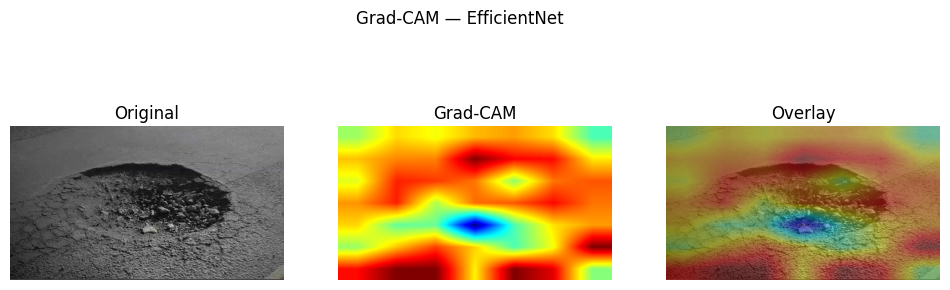

Grad-CAM: ResNet50


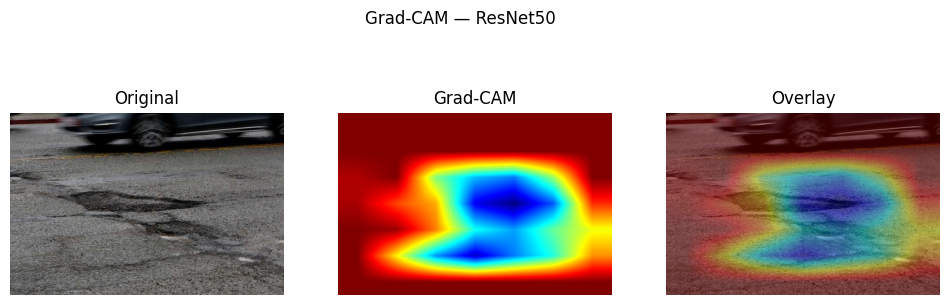

5953

In [64]:
print("Grad-CAM: EfficientNet")
show_random_gradcam(effnet, val_ds, "EfficientNet")

plt.close("all")
torch.cuda.empty_cache()
gc.collect()

print("Grad-CAM: ResNet50")
show_random_gradcam(resnet, val_ds, "ResNet50")

plt.close("all")
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/800 [00:00<?, ?it/s]

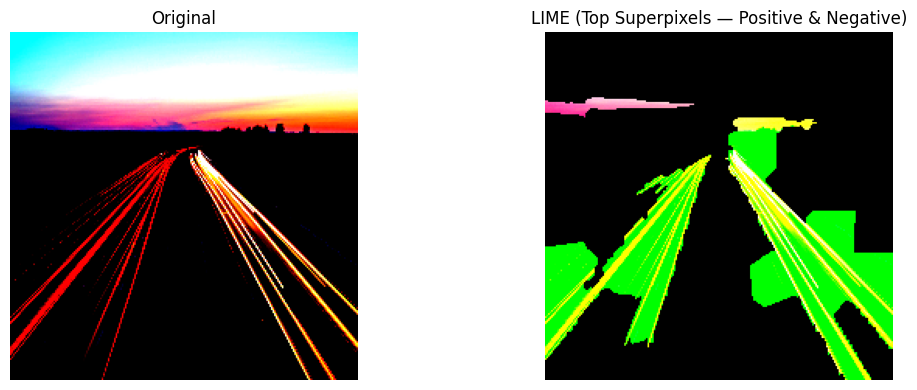

5084

In [61]:
from lime import lime_image
from skimage.segmentation import slic
import numpy as np
import matplotlib.pyplot as plt
import gc
import torch

vit.eval()

example = val_ds[0][0].permute(1, 2, 0).cpu().numpy()
example = np.clip(example, 0, 1)

segments = slic(
    example,
    n_segments=100,
    compactness=12,
    sigma=1,
    start_label=0
)

def lime_predict(imgs):
    batch = []

    for img in imgs:
        if img.max() > 1:
            img = img / 255.0

        img = np.clip(img, 0, 1)

        img = A.Normalize()(image=img)["image"]
        img = img.transpose(2, 0, 1)
        batch.append(img)

    batch = torch.tensor(batch).float().to(device)

    with torch.no_grad():
        probs = torch.softmax(vit(batch), dim=1)

    return probs.cpu().numpy()

# LIME explainer
explainer = lime_image.LimeImageExplainer(random_state=42)

lime_exp = explainer.explain_instance(
    example,
    lime_predict,
    labels=[1],
    segmentation_fn=lambda x: segments,
    num_samples=800,
    top_labels=None
)

lime_img, lime_mask = lime_exp.get_image_and_mask(
    label=1,
    positive_only=False,
    num_features=12,
    hide_rest=True
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(example)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(lime_img)
plt.title("LIME (Top Superpixels — Positive & Negative)")
plt.axis("off")

plt.tight_layout()
plt.show()

plt.close("all")
torch.cuda.empty_cache()
gc.collect()

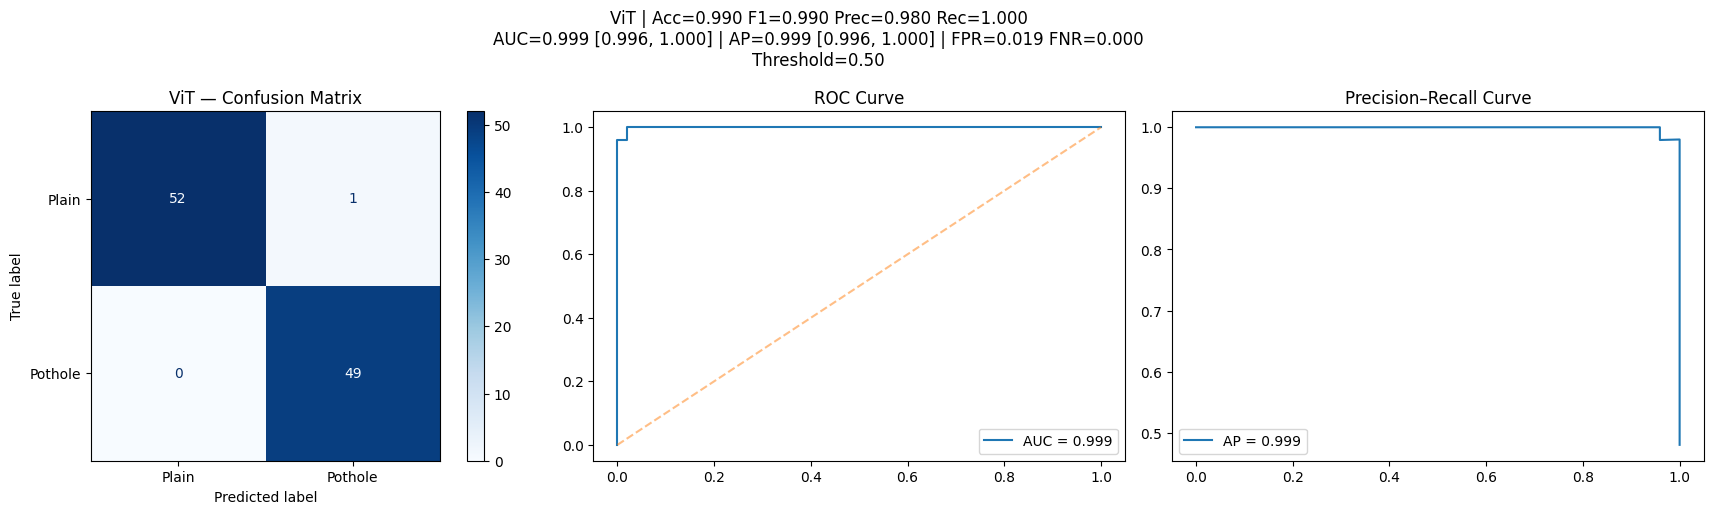

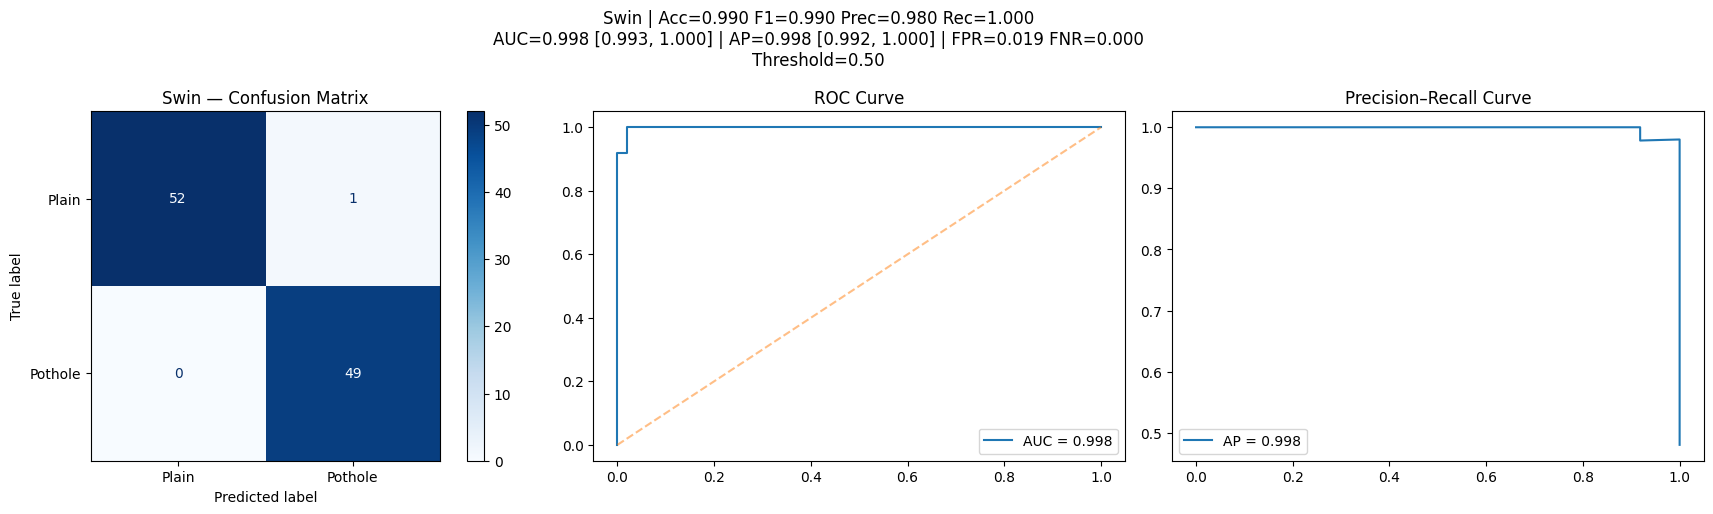

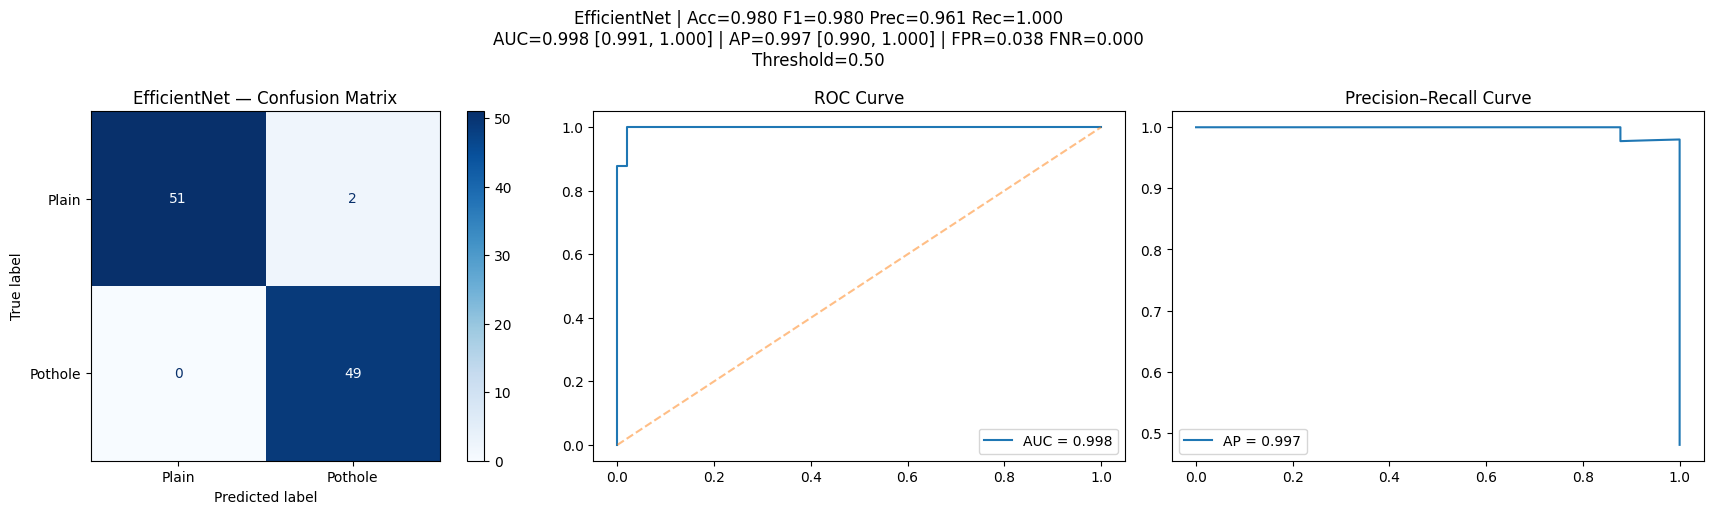

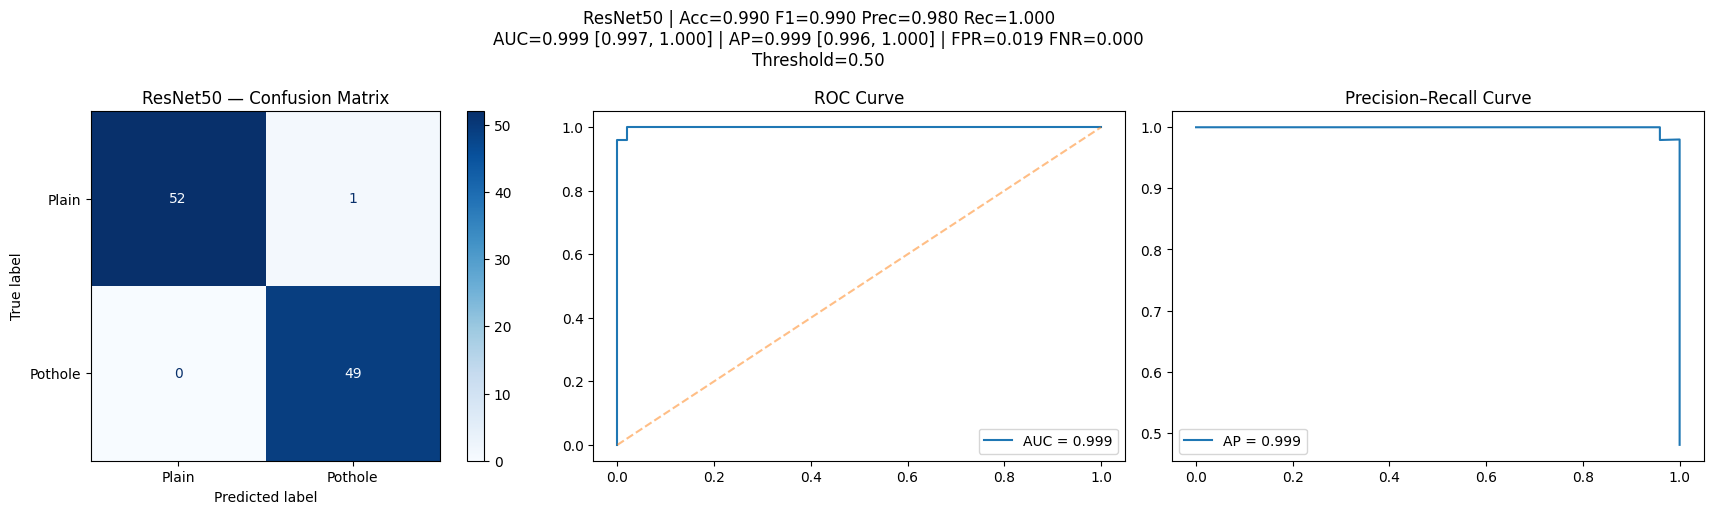

In [27]:
import numpy as np
import torch
import gc
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    f1_score, accuracy_score, precision_score, recall_score
)

BOOTSTRAP_ITERS = 500
POS_LABEL = 1

def bootstrap_ci(y, p, metric_fn, iters=500):
    rng = np.random.default_rng(42)
    vals = []
    for _ in range(iters):
        idx = rng.integers(0, len(y), len(y))
        vals.append(metric_fn(y[idx], p[idx]))
    return np.percentile(vals, [2.5, 97.5])

@torch.no_grad()
def evaluate_model(model, name):
    model.eval()

    y_true, y_prob = [], []

    for x, y in val_loader:
        x = x.to(device)
        prob = torch.softmax(model(x), dim=1)[:, POS_LABEL]
        y_true.extend(y.numpy())
        y_prob.extend(prob.cpu().numpy())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    thr = 0.5
    y_pred = (y_prob >= thr).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    prec_v = precision_score(y_true, y_pred)
    rec_v = recall_score(y_true, y_pred)

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val = auc(fpr, tpr)
    ap = average_precision_score(y_true, y_prob)

    auc_ci = bootstrap_ci(
        y_true, y_prob,
        lambda y, p: auc(*roc_curve(y, p)[:2]),
        BOOTSTRAP_ITERS
    )
    ap_ci = bootstrap_ci(
        y_true, y_prob,
        average_precision_score,
        BOOTSTRAP_ITERS
    )

    cm = confusion_matrix(y_true, y_pred)
    fnr = cm[1, 0] / (cm[1].sum() + 1e-8)
    fpr_val = cm[0, 1] / (cm[0].sum() + 1e-8)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    ConfusionMatrixDisplay(
        cm, display_labels=["Plain", "Pothole"]
    ).plot(ax=axes[0], cmap="Blues", values_format="d")
    axes[0].set_title(f"{name} — Confusion Matrix")

    axes[1].plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    axes[1].plot([0, 1], [0, 1], "--", alpha=0.5)
    axes[1].set_title("ROC Curve")
    axes[1].legend()

    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    axes[2].plot(rec, prec, label=f"AP = {ap:.3f}")
    axes[2].set_title("Precision–Recall Curve")
    axes[2].legend()

    plt.suptitle(
        f"{name} | Acc={acc:.3f} F1={f1:.3f} "
        f"Prec={prec_v:.3f} Rec={rec_v:.3f}\n"
        f"AUC={auc_val:.3f} [{auc_ci[0]:.3f}, {auc_ci[1]:.3f}] | "
        f"AP={ap:.3f} [{ap_ci[0]:.3f}, {ap_ci[1]:.3f}] | "
        f"FPR={fpr_val:.3f} FNR={fnr:.3f}\n"
        f"Threshold={thr:.2f}"
    )

    plt.tight_layout()
    plt.show()

    plt.close("all")
    torch.cuda.empty_cache()
    gc.collect()

models = {
    "ViT": vit,
    "Swin": swin,
    "EfficientNet": effnet,
    "ResNet50": resnet
}

for name, model in models.items():
    evaluate_model(model, name)

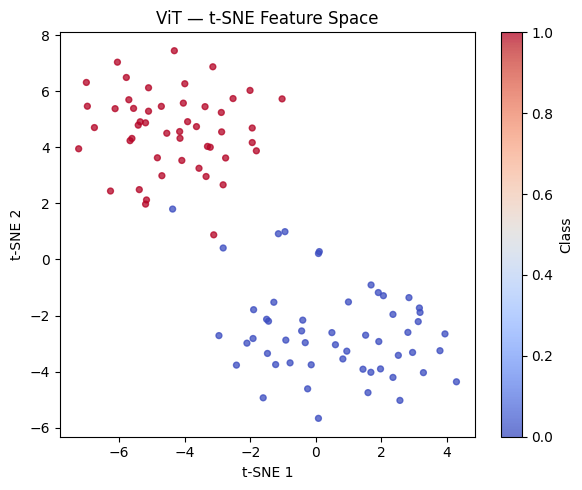

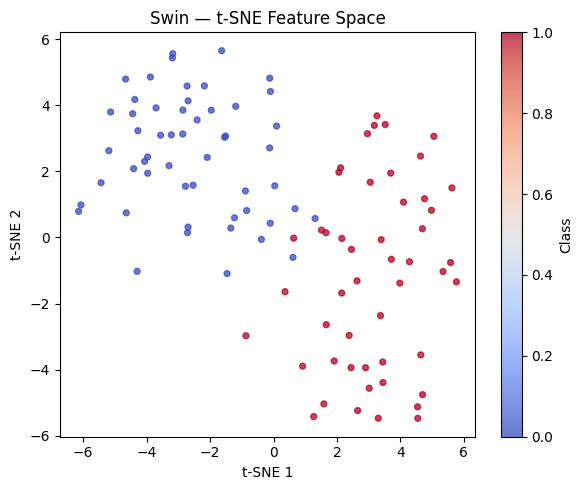

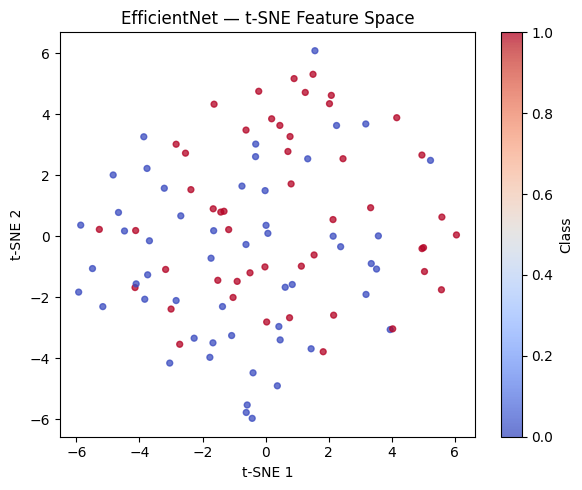

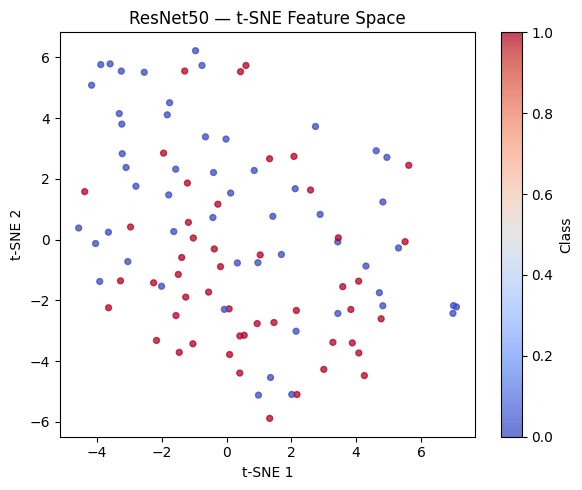

In [28]:
import torch
import numpy as np
import gc
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Embedding extractor
@torch.no_grad()
def get_embeddings(model, loader, device):
    model.eval()
    feats, labels = [], []

    for x, y in loader:
        x = x.to(device)

        if hasattr(model, "forward_features"):
            out = model.forward_features(x)

            if out.ndim == 3:
                emb = out[:, 0]

            elif out.ndim == 4:
                emb = out.mean(dim=(1, 2))

            else:
                raise ValueError(f"Unsupported transformer output: {out.shape}")

        else:
            out = model(x)

            if out.ndim == 4:
                emb = out.mean(dim=(2, 3))
            else:
                emb = out

        feats.append(emb.cpu())
        labels.append(y)

    feats = torch.cat(feats, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    return feats, labels

for name, model in models.items():
    np.random.seed(42)

    idx = np.random.choice(len(val_ds), size=min(400, len(val_ds)), replace=False)
    loader = DataLoader(
        Subset(val_ds, idx),
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    feats, labels = get_embeddings(model, loader, device)

    assert feats.ndim == 2, f"{name}: invalid feature shape {feats.shape}"

    feats = StandardScaler().fit_transform(feats)

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        init="pca",
        learning_rate="auto",
        max_iter=1000,
        random_state=42
    )

    reduced = tsne.fit_transform(feats)

    plt.figure(figsize=(6, 5))
    sc = plt.scatter(
        reduced[:, 0],
        reduced[:, 1],
        c=labels,
        cmap="coolwarm",
        alpha=0.75,
        s=18
    )
    plt.title(f"{name} — t-SNE Feature Space")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.colorbar(sc, label="Class")
    plt.tight_layout()
    plt.show()

    plt.close("all")
    torch.cuda.empty_cache()
    gc.collect()